<a href="https://colab.research.google.com/github/K-107/exercise/blob/main/Informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informer Demo

## Download code and dataset

In [1]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 538 (delta 0), reused 0 (delta 0), pack-reused 535
Receiving objects: 100% (538/538), 6.48 MiB | 12.31 MiB/s, done.
Resolving deltas: 100% (306/306), done.
Cloning into 'ETDataset'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 187 (delta 66), reused 13 (delta 2), pack-reused 0
Receiving objects: 100% (187/187), 3.85 MiB | 11.54 MiB/s, done.
Resolving deltas: 100% (66/66), done.
ETDataset  Informer2020  sample_data


In [2]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [3]:
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 'Informer2020']

In [4]:
!pwd

/content


In [5]:
!ls

ETDataset  Informer2020  sample_data


In [6]:
!pip install -r ./Informer2020/requirements.txt

     |████████████████████████████████| 13.1 MB 7.1 kB/s 
     |████████████████████████████████| 14.5 MB 80 kB/s 
     |████████████████████████████████| 10.4 MB 46.4 MB/s 
     |████████████████████████████████| 6.7 MB 20.7 MB/s 
     |████████████████████████████████| 735.5 MB 15 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: matplotlib
    Found

## Experiments: Train and Test

In [10]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [82]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.do_predict= True # 이걸로 예측한다!
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 3
args.patience = 3
args.des = 'exp'
args.inverse = True # 이걸로 standardscaler 되돌려 놓는다!


args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [83]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [84]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [85]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [86]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': './ETDataset/ETT-small/', 'data_path': 'ETTh1.csv', 'features': 'MS', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 7, 'dec_in': 7, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'do_predict': True, 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 3, 'patience': 3, 'des': 'exp', 'inverse': True, 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [87]:
Exp = Exp_Informer

In [21]:
!pip uninstall numpy -y
!pip install numpy==1.20.1

!pip uninstall pandas -y
!pip install pandas==1.2.2

Found existing installation: numpy 1.19.4
Uninstalling numpy-1.19.4:
  Successfully uninstalled numpy-1.19.4
     |████████████████████████████████| 15.3 MB 107 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires pandas>=1.0, but you have pandas 0.25.1 which is incompatible.
torchvision 0.10.0+cu111 requires torch==1.9.0, but you have torch 1.8.0 which is incompatible.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.0 which is incompatible.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.20.1 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 0.25.1 which is incompatible.
fbprophet 0.7.1 requires pandas>=1.0.4, but you have pandas 0.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

Found existing installation: pandas 0.25.1
Uninstalling pandas-0.25.1:
  Successfully uninstalled pandas-0.25.1
     |████████████████████████████████| 9.9 MB 3.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.2 which is incompatible.


In [88]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 12075
val 1719
test 3461
	iters: 100, epoch: 1 | loss: 144.6929016
	speed: 0.2011s/iter; left time: 207.5761s
	iters: 200, epoch: 1 | loss: 118.1593704
	speed: 0.2007s/iter; left time: 187.0361s
	iters: 300, epoch: 1 | loss: 135.3813019
	speed: 0.2006s/iter; left time: 166.9148s
Epoch: 1 cost time: 75.80700588226318
Epoch: 1, Steps: 377 | Train Loss: 144.1642620 Vali Loss: 36.4549713 Test Loss: 46.0798759
Validation loss decreased (inf --> 36.454971).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 121.9568481
	speed: 0.4999s/iter; left time: 327.4295s
	iters: 200, epoch: 2 | loss: 136.9001617
	speed: 0.2008s/iter; left time: 111.4436s
	iters: 300, epoch: 2 | loss: 116.3308792
	speed: 0.2008s/iter; left time: 91.3852s
Epoch: 2 cost time: 75.66017389297485
Epoch: 2, Steps: 377 | Train 

## 시각화

In [89]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((3456, 24, 7), (3456, 24, 1))

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

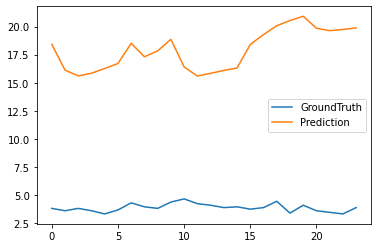

In [91]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

In [27]:
import pandas as pd
import numpy as np

args.root_path = './ETDataset/ETT-small/'
args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))
print(df.head())

                  date       HUFL    HULL  ...   LUFL   LULL         OT
0  2016-07-01 00:00:00  41.130001  12.481  ...  4.424  1.311  38.661999
1  2016-07-01 01:00:00  37.528000  10.136  ...  4.435  1.215  37.124001
2  2016-07-01 02:00:00  37.946999  11.309  ...  2.100  0.000  36.465000
3  2016-07-01 03:00:00  38.952000  11.895  ...  3.380  1.215  33.608501
4  2016-07-01 04:00:00  38.113998  11.476  ...  2.036  0.000  31.850500

[5 rows x 8 columns]


In [28]:
df.OT = 0
df

AttributeError: ignored

                      date       HUFL    HULL  ...    LUFL   LULL  OT
0      2016-07-01 00:00:00  41.130001  12.481  ...   4.424  1.311   0
1      2016-07-01 01:00:00  37.528000  10.136  ...   4.435  1.215   0
2      2016-07-01 02:00:00  37.946999  11.309  ...   2.100  0.000   0
3      2016-07-01 03:00:00  38.952000  11.895  ...   3.380  1.215   0
4      2016-07-01 04:00:00  38.113998  11.476  ...   2.036  0.000   0
...                    ...        ...     ...  ...     ...    ...  ..
17415  2018-06-26 15:00:00  39.202999  11.392  ... -10.331 -1.258   0
17416  2018-06-26 16:00:00  38.113998  10.974  ... -10.331 -1.290   0
17417  2018-06-26 17:00:00  39.622002  10.974  ... -11.557 -1.418   0
17418  2018-06-26 18:00:00  43.643002  13.403  ... -10.299 -1.418   0
17419  2018-06-26 19:00:00  38.868000  10.052  ... -11.525 -1.418   0

[17420 rows x 8 columns]

In [30]:
!pip uninstall pandas
!pip install pandas==1.1.5

Found existing installation: pandas 1.2.2
Uninstalling pandas-1.2.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.2.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? ㅛ
Your response ('ㅛ') was not one of the expected responses: y, n
Proceed (y/n)? ㅛ
Your response ('ㅛ') was not one of the expected responses: y, n
Proceed (y/n)? y
  Successfully uninstalled pandas-1.2.2
     |████████████████████████████████| 9.5 MB 4.2 MB/s 


In [48]:
df_0 = df.iloc[0]
df_0

date    2016-07-01 00:00:00
HUFL                  41.13
HULL                 12.481
MUFL                 36.536
MULL                  9.355
LUFL                  4.424
LULL                  1.311
OT                        0
Name: 0, dtype: object

In [49]:
df_0.to_csv("./ETDataset/ETT-small/df_0.csv", index=False)
pd.read_csv('./ETDataset/ETT-small/df_0.csv')

AttributeError: ignored

                     0
0  2016-07-01 00:00:00
1    41.13000106811523
2   12.480999946594238
3     36.5359992980957
4    9.354999542236328
5    4.423999786376953
6   1.3109999895095823
7                    0

## Prediction

In [8]:
!pwd

/content


In [9]:
# import os

# # set saved model path
# setting = 'informer_custom_ftMS_sl80_ll40_pl20_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# # path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

# 예측!

In [ ]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
args.root_path = './ETDataset/ETT-small/'
args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [ ]:
# df.head()

In [ ]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os



args.root_path = './ETDataset/ETT-small/'
args.data_path = 'df_0.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))


args.target = 'OT'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [68]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'df_0.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 1 # input sequence length of Informer encoder
args.label_len = 1 # start token length of Informer decoder
args.pred_len = 1 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.do_predict= True
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 1
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 3
args.patience = 3
args.des = 'exp'
args.inverse = True

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [69]:
for ii in range(args.itr):
    # setting record of experiments
    setting = 'informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'

    if args.do_predict:
        print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.predict(setting, True)

    torch.cuda.empty_cache()

>>>>>>>predicting : informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
pred 1


In [70]:
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 24, 7)

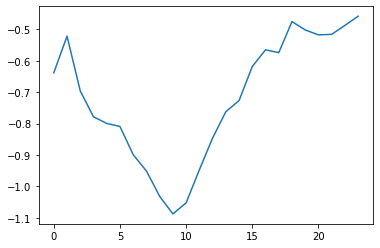

In [71]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

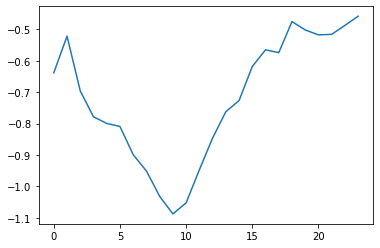

In [72]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

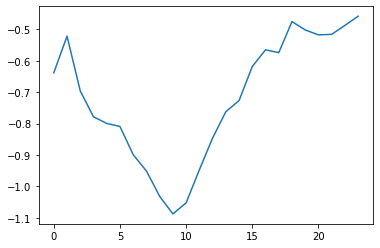

In [73]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

# 최종결론!

쭈욱 데이터를 학습해서 그 다음부터의 시퀀스를 예측하는 것에 걸맞는 것이다.
아예 이 모델은 데이터에서 학습한 뒤에 붙여서 예측하는 것밖에 못한다.

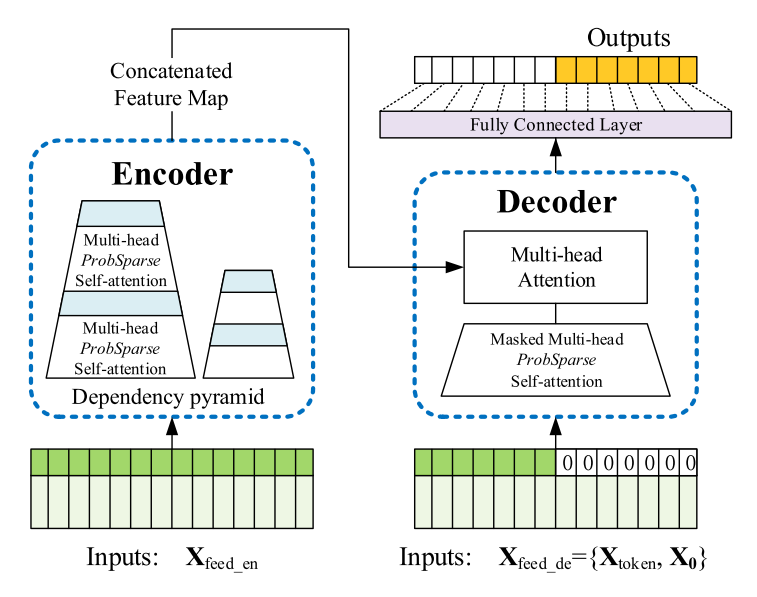

오토 리그레시브하게 생성하는 것이다.

# 즉, 예측값이 0인 걸 넣는게 아니라, 훈련 데이터를 넣고 그 다음을 예측하는 것이다!